In [1]:
%reset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import scipy.stats
import mne
from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_1samp_test
import gc
import os
import copy
import pickle
from os.path import exists
import mne
import numpy as np
from mne import create_info
from IPython.utils import io
import yasa
import seaborn as sns

gc.collect()

Nothing done.


0

In [2]:
pkl_dir = "C:\\Users\\User\\Cloud-Drive\\BigFiles\\OmissionExpOutput\\preProcessed_eventDetection7Electrodes_plainEEGLAB"
import_type = "eventDetection7Electrodes_plainEEGLAB"
output_dir_name = 'spindleDetection\\done_on_preProcessed'

In [3]:
import_path = f'{pkl_dir}\\{import_type}.pkl'

with open(import_path, "rb") as file:
    [allsubsdata_perFile, configu] = pickle.load(file)

fig_output_dir = f"{configu['outputs_dir_path']}/{output_dir_name}"
if not os.path.exists(fig_output_dir):
    os.mkdir(fig_output_dir)

One file yasa detection 

In [24]:
sub = '32'
datafile = 2
id = f"{sub}_{datafile}"

datafile_data = allsubsdata_perFile[id]['data'] ## shape (electrode, time)
datafile_scoring = allsubsdata_perFile[id]['scoring'] ## shape (time/sampling/30)

exmp_scoring_upsampled = yasa.hypno_upsample_to_data(datafile_scoring, 1/30, datafile_data, sf_data=configu['sample_freq'], verbose=True)
sp = yasa.spindles_detect(datafile_data,sf=configu['sample_freq'], hypno = exmp_scoring_upsampled,include=[2, 3],ch_names=configu['electrodes_names'],multi_only=True)
print(sp)
print(sp.summary())
# sp.plot_average(center='Peak',time_before = 1,time_after = 1)
# plt.show()
#%matplotlib widget
#sp.plot_detection()

19-Jan-23 16:34:26 | WARNING | Hypnogram is SHORTER than data by 26.41 seconds. Padding hypnogram with last value to match data.size.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:   

       Start      Peak       End  Duration  Amplitude        RMS  AbsPower  \
0   1142.270  1142.702  1142.962     0.692  47.222215   9.723708  1.686189   
1   1597.234  1597.668  1597.816     0.582  40.301993   8.635754  2.093590   
2   4871.238  4871.494  4871.816     0.578  31.771769   6.799881  1.798298   
3   4879.756  4880.140  4880.418     0.662  41.491032   9.640495  2.166930   
4   5556.016  5556.214  5556.628     0.612  29.983411   7.334559  1.850750   
..       ...       ...       ...       ...        ...        ...       ...   
79  5984.478  5984.888  5985.152     0.674  65.681881  13.430062  2.342017   
80  6048.114  6048.458  6048.688     0.574  37.529777   8.979691  1.947912   
81  6070.572  6071.246  6071.642     1.070  68.238521  14.503426  2.387073   
82  7429.046  7429.696  7429.936     0.890  83.599248  19.085602  2.613324   
83  8035.736  8036.084  8036.580     0.844  86.304989  18.858488  2.353703   

    RelPower  Frequency  Oscillations  Symmetry  Stage Channel 

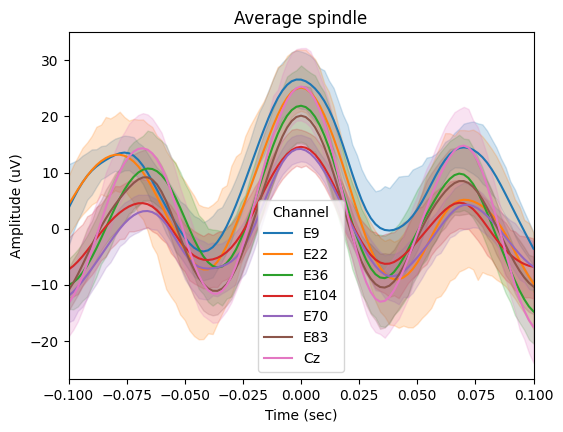

In [27]:
%matplotlib inline
sp.plot_average(center='Peak', time_before=0.1, time_after=0.1);

Batch yasa detection and save

In [ ]:
yasa_output_dir = f"{configu['outputs_dir_path']}/{output_dir_name}/yasa"
if not os.path.exists(yasa_output_dir):
    os.mkdir(yasa_output_dir)

for id in allsubsdata_perFile:
    datafile_data = allsubsdata_perFile[id]['data'] ## shape (electrode, time)
    datafile_scoring = allsubsdata_perFile[id]['scoring'] ## shape (time/sampling/30)
    if 2 not in datafile_scoring or 3 not in datafile_scoring:
        continue

    exmp_scoring_upsampled = yasa.hypno_upsample_to_data(datafile_scoring, 1/30, datafile_data, sf_data=configu['sample_freq'], verbose=False)
    sp = yasa.spindles_detect(datafile_data,sf=configu['sample_freq'], hypno = exmp_scoring_upsampled,include=[2, 3],ch_names=configu['electrodes_names'],multi_only=True)
    #summary_df  = sp.summary()
    summary_df.to_csv(f"{yasa_output_dir}\\{allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}_yasaSpindles.csv")
    sp.plot_average(center='Peak', time_before=1, time_after=1)
    plt.savefig(f"{yasa_output_dir}\\{allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}_yasaSpindles_average.png")

One file Nir&Andrillon Detection

In [33]:
import matlab
import matlab.engine

sub = '32'
datafile = 2 
id = f"{sub}_{datafile}"

datafile_data = allsubsdata_perFile[id]['data'] ## shape (electrode, time)
datafile_scoring = allsubsdata_perFile[id]['scoring'] ## shape (time/sampling/30)
datafile_data_cz = datafile_data[1,:]
exmp_scoring_upsampled = yasa.hypno_upsample_to_data(datafile_scoring, 1/30, datafile_data_cz, sf_data=configu['sample_freq'], verbose=True)

eng = matlab.engine.start_matlab()
eng.SpindlesDetectionAlgorithm_fieldtrip(np.array(datafile_data_cz), configu['sample_freq'], np.array(exmp_scoring_upsampled))

#spindles, spindlesOutEnergy, spindlesOutDuration, rej_cand = eng.SpindlesDetectionAlgorithm_fieldtrip(datafile_data_cz, configu['sample_freq'], exmp_scoring_upsampled)

eng.quit()

19-ינו-23 17:06:51 | WARNING | Hypnogram is SHORTER than data by 26.41 seconds. Padding hypnogram with last value to match data.size.


MatlabExecutionError: Undefined function 'SpindlesDetectionAlgorithm_fieldtrip' for input arguments of type 'int64'.


Batch Nir&Andrillon Detection

In [36]:
import matlab
import matlab.engine
import os

andriNir_code_dir = "C:\\Users\\User\\Cloud-Drive\\AnatArzi\\scripts\\Matlab_scripts - Sharons\\Andrillon_Nir_Algo"
andriNir_output_dir = f"{configu['outputs_dir_path']}/{output_dir_name}/Andrillon_Nir"
if not os.path.exists(andriNir_output_dir):
    os.mkdir(andriNir_output_dir)

electrode_num = 6
electrode_name = configu['electrodes_names'][electrode_num]

## create aux files to use in MATLAB
for id in allsubsdata_perFile:
    datafile_data = allsubsdata_perFile[id]['data'] ## shape (electrode, time)
    datafile_scoring = allsubsdata_perFile[id]['scoring'] ## shape (time/sampling/30)
    datafile_1elect_eeg = datafile_data[electrode_num,:]
    if 2 not in datafile_scoring or 3 not in datafile_scoring:
        continue

    exmp_scoring_upsampled = yasa.hypno_upsample_to_data(datafile_scoring, 1/30, datafile_1elect_eeg, sf_data=configu['sample_freq'], verbose=True)
    mat_to_save =  {'datafile_data': datafile_1elect_eeg, 'exmp_scoring_upsampled': exmp_scoring_upsampled, 'sample_freq': configu['sample_freq'], 'electrode_name':electrode_name}
    scipy.io.savemat(f"{andriNir_output_dir}\\{allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}_{electrode_name}AndScoring.mat",mat_to_save)

## run Andrillon & Nir SS detection over all subjects files
eng = matlab.engine.start_matlab()
eng.cd(andriNir_code_dir, nargout=0)
out = eng.batch_useSpindlesDetection(andriNir_output_dir, andriNir_output_dir,nargout=0)
eng.quit()

## delete aux files
all_files_in_outputDir = os.listdir(andriNir_output_dir)
for file_in_outputDir in all_files_in_outputDir:
    if file_in_outputDir.endswith(".mat") and not file_in_outputDir.startswith("Spindles_andrillonNir"):
        os.remove(os.path.join( andriNir_output_dir, file_in_outputDir ) )


21-ינו-23 16:40:31 | WARNING | Hypnogram is SHORTER than data by 4.94 seconds. Padding hypnogram with last value to match data.size.
21-ינו-23 16:40:31 | WARNING | Hypnogram is SHORTER than data by 26.41 seconds. Padding hypnogram with last value to match data.size.
21-ינו-23 16:40:32 | WARNING | Hypnogram is SHORTER than data by 25.70 seconds. Padding hypnogram with last value to match data.size.
21-ינו-23 16:40:32 | WARNING | Hypnogram is SHORTER than data by 2.56 seconds. Padding hypnogram with last value to match data.size.
21-ינו-23 16:40:32 | WARNING | Hypnogram is SHORTER than data by 23.19 seconds. Padding hypnogram with last value to match data.size.
21-ינו-23 16:40:32 | WARNING | Hypnogram is SHORTER than data by 22.21 seconds. Padding hypnogram with last value to match data.size.
21-ינו-23 16:40:32 | WARNING | Hypnogram is SHORTER than data by 0.64 seconds. Padding hypnogram with last value to match data.size.
21-ינו-23 16:40:33 | WARNING | Hypnogram is SHORTER than data by 

MatlabExecutionError: 
  File C:\Users\User\Cloud-Drive\AnatArzi\scripts\Matlab_scripts - Sharons\Andrillon_Nir_Algo\batch_useSpindlesDetection.m, line 14, in batch_useSpindlesDetection
Unrecognized field name "datafile_data".


In [33]:
andriNir_output_dir

'C:\\Users\\User\\Cloud-Drive\\BigFiles\\OmissionExpOutput/spindleDetection\\done_on_preProcessed/Andrillon_Nir'

In [9]:
sub = '32'
datafile = 2 
id = f"{sub}_{datafile}"

datafile_data = allsubsdata_perFile[id]['data'] ## shape (electrode, time)
datafile_scoring = allsubsdata_perFile[id]['scoring'] ## shape (time/sampling/30)

In [26]:
def format_scoring_to_edfViewer(score):
    if score == 0:
        return 'W'
    elif score ==1:
        return 'N1'
    elif score ==2:
        return 'N2'
    elif score ==3:
        return 'N3'
    elif score ==4:
        return 'TREM'
    elif score ==5:
        return 'PREM'
    elif score ==6:
        return 'MOVE'
    elif score ==7:
        return 'ARTIFACT'
    else:
        Exception('no such score')

In [29]:
new_format_score = np.zeros((len(datafile_scoring),3), dtype=object)
for ind, score in enumerate(datafile_scoring):
        new_format_score[ind,:] = [format_scoring_to_edfViewer(score),30*ind,30] ## desc, onset (sec), duration

np.savetxt('test2.txt', new_format_score, delimiter='\t',fmt='%s')


In [24]:
enumerate(datafile_scoring)

In [37]:
andriNir_output_dir

'C:\\Users\\User\\Cloud-Drive\\BigFiles\\OmissionExpOutput/spindleDetection\\done_on_preProcessed/Andrillon_Nir'